# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function computes the probabilities that the new input belongs to all classes and
then returns the class that has the largest probability, i.e., makes a prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma^2)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html

Example: https://stackoverflow.com/questions/12412895/how-to-calculate-probability-in-a-normal-distribution-given-mean-standard-devi


**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [2]:
ALPHA = 1.0 # for additive smoothing
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multinomial
# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.mean = np.mean(X)
        self.std = np.std(X)
        if self.std == 0:
            self.std = 1e-6
        
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.prob = norm.logpdf(X_new, self.mean, self.std)
        return self.prob
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        # X is a vector with binary values
        self.theta = (np.sum(X)+ ALPHA)/(len(X)+2*ALPHA)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.prob = bernoulli.logpmf(X_new,self.theta)
        return self.prob
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        countvalue = np.bincount(X,minlength = self._num_of_categories)##Count number of occurrences of each value in array of non-negative ints.
        #minlength avoid input class > real class
        self.p_single =[]
        
        for i in range(self._num_of_categories):
            self.p_single.append((countvalue[i]  + ALPHA)/(len(X) + self._num_of_categories*ALPHA))
        
       
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        # define the parameters of the distribution
        
        if type(X_new) == np.int64:
            return np.log(self.p_single[X_new])
            
        self.prob = []
        for inew in X_new:
            self.prob.append(np.log(self.p_single[inew]))
        
        return self.prob
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

**Tests:**
    
We will use the code below to test the correctness of your code.

In [3]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [4]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [5]:
# categorical features (bonus task)
 
# N= 25，each number stands for which category 
X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.9459101490553135, -2.169053700369523, -1.9459101490553135, -2.456735772821304, -2.169053700369523, -2.8622008809294686, -1.9459101490553135, -3.5553480614894135, -2.169053700369523, -2.8622008809294686]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [11]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[],num_of_categories=[]):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.feature_types = feature_types
        self.num_of_categories = num_of_categories
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.classes_y = np.unique(y)
        self.thetas = []
        self.pai = []
        for c in range(len(self.classes_y)): # go through classes
            thetas_c = []
            class_condition = y == c
            self.pai.append(max(np.mean(class_condition), 1e-6))
           
            for j, r in enumerate(self.feature_types): 
                
                if r == "b":     
                    theta_jc = BinFeatureParam()      
                elif r == "r":
            
                    theta_jc = ContFeatureParam()
                    
                elif r == "c":
                    theta_jc = CatFeatureParam(num_of_categories=self.num_of_categories[j])
                else:
                    print("Wrong Feature Types")
                
                X_jc = X[class_condition, j]  
                theta_jc.estimate(X_jc)
                thetas_c.append(theta_jc)
                    
              
            self.thetas.append(thetas_c)
           
             
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
                
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        #N,_ = X.shape
        self.logprob=[]
        self.log_prob_all = []
        logpai = np.log(self.pai)
        for c in range(len(self.classes_y)): ### number of class
            logpai_c=logpai[c]# Initial the probability with prior probablity
            for j in range(len(self.feature_types)):   
                X_j=X[:,j]# Data for every feature
                self.prob2 = self.thetas[c][j].get_log_probability(X_j) # P(x^{j} | y = c)
                logpai_c = logpai_c + self.prob2 # multiply the probablity of each feature
                
            self.log_prob_all.append(logpai_c)

        ypred = np.argmax(self.log_prob_all, axis = 0)#According to data use the index of the max probablity to predict
        return ypred
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


**Tests**

We will use the code below to check your code.

In [12]:
# All features of the iris dataset are continuous.
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [13]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [18]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./categorical_test.csv', header=None)
data = data.to_numpy()
num_of_categories = []
X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

for i in range(D):
    num_of_categories.append(len(np.unique(X[:,i])))
nbc = NBC(feature_types=['c'] * 9, num_of_categories=num_of_categories)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 

Accuracy: 0.6896551724137931
[0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


## Logistic Regression

For logistic regression (LR), you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [19]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [20]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = []
    tst_errs_lr = []
    
    for i in range(num_runs):
        N, D = X.shape
        Ntrain = int(0.8 * N)
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]
        N_Xtrain, D_Xtrain = Xtrain.shape
        tst_errs_nbc1 = []
        tst_errs_lr1 = []

        for train_size in range(N_Xtrain//10, N_Xtrain+1, N_Xtrain//num_splits):
            X_train = Xtrain[:train_size]
            y_train = ytrain[:train_size]

            # NBC

            nbc = nbc
            nbc.fit(X_train, y_train)
            predicted_nbc = nbc.predict(Xtest)
            errs_nbc = 1 - np.mean(predicted_nbc == ytest)
            tst_errs_nbc1.append(errs_nbc)
            
             # LR

            lr = lr
            lr.fit(X_train, y_train)
            predicted_lr = lr.predict(Xtest)
            errs_lr = 1 - np.mean(predicted_lr == ytest)
            tst_errs_lr1.append(errs_lr)

        
        tst_errs_lr.append(tst_errs_lr1)
        tst_errs_nbc.append(tst_errs_nbc1)
            
    tst_errs_lr = np.mean(tst_errs_lr, axis = 0)
    tst_errs_nbc = np.mean(tst_errs_nbc, axis = 0)
    
    
    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

In [21]:
def makePlot(tst_errs_nbc, tst_errs_lr, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, tst_errs_nbc, label='Naive Bayes')
    plt.plot(xaxis_scale, tst_errs_lr, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

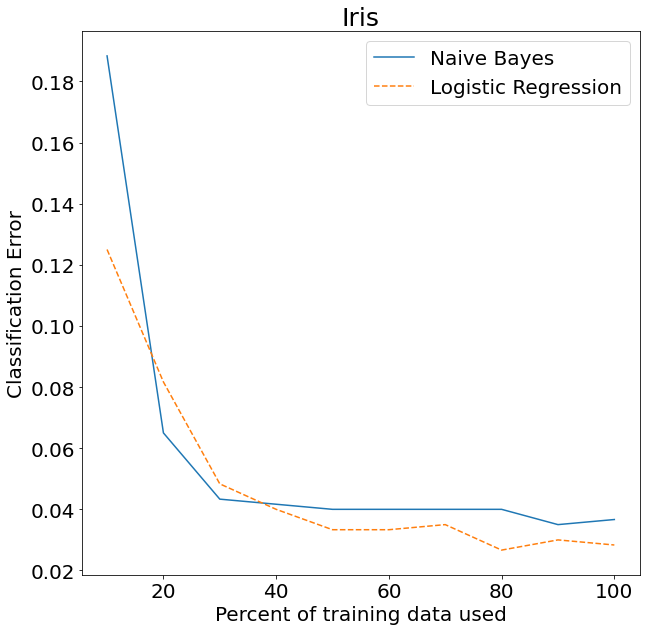

In [22]:
import random
SEED = 31
random.seed(SEED)
np.random.seed(SEED)

# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
lr_iris = LogisticRegression(max_iter=150)

nbc_perf_iris, lr_perf_iris = compareNBCvsLR(nbc_iris, lr_iris, X, y, num_runs=20)

makePlot(nbc_perf_iris, lr_perf_iris, 'Iris')
#in this example, we first load the iris dataset, then slice dataset to get X and y.
# we know X is (150,4) matrix, there are no missing values
#and the type of each column of X is r,r,r,r which are binary. 
#Then we made plot to compare Naive Bayes Classifier and logistic regreesion classifier. 
#we can see that NBC starts with a higher classification error. They both converge. 
#The logistic regression classifier has a smaller classfication error than naive bayes classifier
#Overall, they both behave well.

###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

In [23]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################

import pandas as pd
import numpy as np
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
voting = pd.read_csv('./voting.csv')

voting = voting.dropna() 
voting = pd.DataFrame(data=voting)#covert to dataframe

for col in voting.columns:
    voting[col] = le.fit(voting[col]).transform(voting[col])  
voting = voting.to_numpy()

voting = voting[:100,:]#choose 100 dataset
X_voting = voting[:,1:]
y_voting = voting[:,0]

print("X_voting:")
print(X_voting)
print("X_voting shape:",X_voting.shape)
print("y_voting:", y_voting)


X_voting:
[[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 0 1]
 [1 1 1 ... 0 1 1]
 ...
 [0 0 1 ... 1 1 1]
 [1 1 1 ... 0 1 1]
 [1 0 1 ... 0 1 1]]
X_voting shape: (100, 16)
y_voting: [0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0
 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0
 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


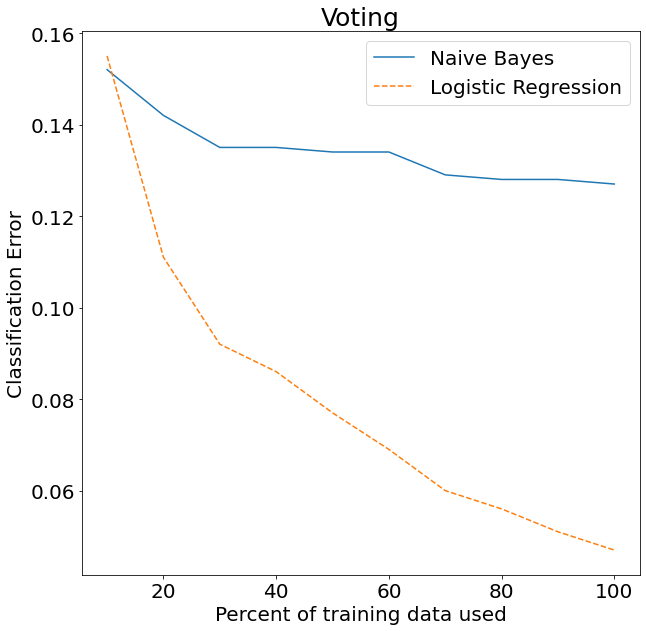

In [24]:
nbc_voting = NBC(feature_types=['b'] * 16)
lr_voting = LogisticRegression(max_iter=150)

nbc_perf_voting, lr_perf_voting = compareNBCvsLR(nbc_voting, lr_voting, X_voting, y_voting, num_runs=50)

makePlot(nbc_perf_voting, lr_perf_voting, 'Voting')
#in this example, we find that there are missing values.
#so we first drop all missing values,and then transfer values to boolean values 0 and 1
#Then we take first 100 dataset of voting dataset. And slice dataset to get X and y
#we find that X has 16 features and their types are binary.(we let them become binary before)
#Then we compare Naive Bayes Classifier and logistic regression classifier
#Finally, we make plot to see the difference. 
#Though the logistic regression classifier doesn't converge in our condition, it decreases largely and arrives at a small classfication error.
#However, the Naive Bayes Classifier decreases a little bit with a high classification error.
#Obviously, logistic regression classfier is better in this case.
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################